# Protein Label Prediction
CS6140 Calvin Lo

## Setup
Load the data from Open Graph Benchmark

In [ ]:
import torch
from ogb.nodeproppred import NodePropPredDataset

original_torch_load = torch.load
def torch_load_with_weights_only_false(*args, **kwargs):
    kwargs['weights_only'] = False
    return original_torch_load(*args, **kwargs)

torch.load = torch_load_with_weights_only_false

# Load the dataset
dataset = NodePropPredDataset(name="ogbn-proteins", root="dataset/")

# Restore torch.load to its original function
torch.load = original_torch_load
split_idx = dataset.get_idx_split()  # which ones are training nodes, val, etc

Dataset loaded successfully!


graph_data: 
- edge_index: COO format (coordinate format) 
    - shape: (2, 79122504)
    - 79122504 edges
    - 0: source node, 1: destination node
- edge_feat:
    - shape: (79122504, 8)
    - 8 dimensional feature vector for each edge
- node_feat:
    - Node features: none for this dataset
- node_species:
    - shape: (132534, 1)
    - Species identifiers for each node
- num_nodes:
    - 132534 nodes

node_labels:
- shape: (132534, 112)
- 112 types of labels

Prepare data for training: Create masks for train, val, and test nodes. Load the data into a PyGeometric data object. Create 40 batches using RandomNodeLoader.

In [2]:
from torch_geometric.utils import scatter
from torch_geometric.loader import RandomNodeLoader
from torch_geometric.data import Data
import gc

# Access the single graph
graph_data, node_labels = dataset[0]

# Split the nodes based on the split indices
split_idx = dataset.get_idx_split()  # which ones are training, val, test nodes
train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx = split_idx["test"]

# Create masks
train_mask = torch.zeros(graph_data['num_nodes'], dtype=torch.bool)
valid_mask = torch.zeros(graph_data['num_nodes'], dtype=torch.bool)
test_mask = torch.zeros(graph_data['num_nodes'], dtype=torch.bool)

train_mask[train_idx] = True
valid_mask[valid_idx] = True
test_mask[test_idx] = True

# Convert edge features and edge index to tensors
graph_data['edge_feat'] = torch.tensor(graph_data['edge_feat'], dtype=torch.float32)
graph_data['edge_index'] = torch.tensor(graph_data['edge_index'], dtype=torch.long)
node_labels = torch.tensor(node_labels, dtype=torch.long)
num_nodes = int(graph_data['num_nodes'])

# initialize node features by aggregating edge features
graph_data['node_feat'] = scatter(graph_data['edge_feat'], 
                                  graph_data['edge_index'][1],
                                  dim=0,
                                  dim_size=graph_data['num_nodes'],
                                  reduce='sum')

# load graph into PyG data object
data = Data(
    edge_index=graph_data['edge_index'],
    edge_attr=graph_data['edge_feat'],
    num_nodes=num_nodes,
    y=node_labels,
    x=graph_data['node_feat'],
    train_mask=train_mask,
    valid_mask=valid_mask,
    test_mask=test_mask
)


train_loader = RandomNodeLoader(data, num_parts=40, shuffle=True,
                                num_workers=0)
test_loader = RandomNodeLoader(data, num_parts=10, num_workers=0)


# Delete unnecessary variables
del graph_data
del node_labels
del split_idx
del train_idx
del valid_idx
del test_idx
del train_mask
del valid_mask
del test_mask

# Force garbage collection to free up memory
gc.collect()


20

In [3]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import torch
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from torch.nn import LayerNorm, Linear, ReLU
from tqdm import tqdm
from torch_geometric.loader import RandomNodeLoader
from torch_geometric.nn import DeepGCNLayer, GENConv
from torch_geometric.utils import scatter

class DeeperGCN(torch.nn.Module):
    def __init__(self, in_channels, edge_in_channels, hidden_channels, num_classes, num_layers):
        super().__init__()
        torch.manual_seed(12345)

        self.node_encoder = Linear(in_channels, hidden_channels)    
        self.edge_encoder = Linear(edge_in_channels, hidden_channels)
        self.layers = torch.nn.ModuleList()

        for i in range(0, num_layers):
            # num_layers is layers in MLP
            conv = GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(hidden_channels, elementwise_affine=True)
            act = ReLU(inplace=True)
            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1)
            self.layers.append(layer)

        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, edge_feat):
        # encode node and edge features to higher dimensional space
        h = self.node_encoder(x)
        edge_embeddings = self.edge_encoder(edge_feat)

        # pass through layers
        for layer in self.layers:
            h = layer(h, edge_index, edge_embeddings)
  
        # drop out and classifier
        h = F.dropout(h, p=0.1, training=self.training)
        h = self.lin(h)
        
        return h
    

def train(model, optimizer, criterion, train_loader, epoch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    total_loss = total_examples = 0
    pbar = tqdm(total=len(train_loader))
    pbar.set_description(f'Training epoch: {epoch:04d}')

    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask].float())
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * int(batch.train_mask.sum())
        total_examples += int(batch.train_mask.sum())
        torch.cuda.empty_cache()
        pbar.update(1)

    pbar.close()

    return total_loss / total_examples

@torch.no_grad()
def test(model, test_loader, epoch, device, evaluator):
    model.eval()

    y_true = {'train': [], 'valid': [], 'test': []}
    y_pred = {'train': [], 'valid': [], 'test': []}

    pbar = tqdm(total=len(test_loader))
    pbar.set_description(f'Evaluating epoch: {epoch:04d}')

    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.edge_attr)

        for split in y_true.keys():
            mask = batch[f'{split}_mask']
            y_true[split].append(batch.y[mask].cpu())
            y_pred[split].append(out[mask].cpu())
        torch.cuda.empty_cache()
        pbar.update(1)

    pbar.close()

    train_rocauc = evaluator.eval({
        'y_true': torch.cat(y_true['train'], dim=0),
        'y_pred': torch.cat(y_pred['train'], dim=0),
    })['rocauc']

    valid_rocauc = evaluator.eval({
        'y_true': torch.cat(y_true['valid'], dim=0),
        'y_pred': torch.cat(y_pred['valid'], dim=0),
    })['rocauc']

    test_rocauc = evaluator.eval({
        'y_true': torch.cat(y_true['test'], dim=0),
        'y_pred': torch.cat(y_pred['test'], dim=0),
    })['rocauc']

    return train_rocauc, valid_rocauc, test_rocauc

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeeperGCN(in_channels=8,
                  edge_in_channels=8,
                  hidden_channels=64,
                  num_classes=112,
                  num_layers=50).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
evaluator = Evaluator('ogbn-proteins')


Training block

In [5]:
epochs = 100
patience = 10
delta = 0.001
best_val_score = None
early_stop_counter = 0

train_losses = []
rocauc = []

for epoch in range(1, epochs + 1):
    loss = train(model, optimizer, criterion, train_loader, epoch)
    train_losses.append(loss)

    train_rocauc, valid_rocauc, test_rocauc = test(model, test_loader, epoch, device, evaluator)
    rocauc.append((train_rocauc, valid_rocauc, test_rocauc))

    print(f'[Epoch {epoch}] Loss: {loss:.4f}, Train: {train_rocauc:.4f}, '
          f'Val: {valid_rocauc:.4f}, Test: {test_rocauc:.4f}')

    # Early stopping logic
    if best_val_score is None or valid_rocauc > best_val_score + delta:
        best_val_score = valid_rocauc
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model_60_layers.pt')
        print(f"New best model saved (Val ROC AUC: {valid_rocauc:.4f})")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stop counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

Evaluating epoch: 0001: 100%|██████████| 10/10 [13:01<00:00, 78.12s/it]


[Epoch 1] Loss: 1.3865, Train: 0.7296, Val: 0.6974, Test: 0.6483
New best model saved (Val ROC AUC: 0.6974)


Evaluating epoch: 0002: 100%|██████████| 10/10 [13:12<00:00, 79.24s/it]


[Epoch 2] Loss: 0.3472, Train: 0.7855, Val: 0.7696, Test: 0.7198
New best model saved (Val ROC AUC: 0.7696)


Evaluating epoch: 0003: 100%|██████████| 10/10 [12:49<00:00, 76.94s/it]


[Epoch 3] Loss: 0.3040, Train: 0.7986, Val: 0.7763, Test: 0.7242
New best model saved (Val ROC AUC: 0.7763)


Evaluating epoch: 0004: 100%|██████████| 10/10 [13:25<00:00, 80.53s/it]


[Epoch 4] Loss: 0.3293, Train: 0.7951, Val: 0.7720, Test: 0.7261
No improvement. Early stop counter: 1/10


Evaluating epoch: 0005: 100%|██████████| 10/10 [12:41<00:00, 76.20s/it]


[Epoch 5] Loss: 0.2908, Train: 0.8106, Val: 0.7889, Test: 0.7441
New best model saved (Val ROC AUC: 0.7889)


Evaluating epoch: 0006: 100%|██████████| 10/10 [13:15<00:00, 79.59s/it]


[Epoch 6] Loss: 0.2840, Train: 0.8169, Val: 0.7959, Test: 0.7550
New best model saved (Val ROC AUC: 0.7959)


Evaluating epoch: 0007: 100%|██████████| 10/10 [13:12<00:00, 79.23s/it]


[Epoch 7] Loss: 0.2840, Train: 0.8257, Val: 0.8022, Test: 0.7542
New best model saved (Val ROC AUC: 0.8022)


Evaluating epoch: 0008: 100%|██████████| 10/10 [13:20<00:00, 80.06s/it]


[Epoch 8] Loss: 0.2783, Train: 0.8299, Val: 0.8040, Test: 0.7563
New best model saved (Val ROC AUC: 0.8040)


Evaluating epoch: 0009: 100%|██████████| 10/10 [13:02<00:00, 78.23s/it]


[Epoch 9] Loss: 0.2746, Train: 0.8367, Val: 0.8088, Test: 0.7552
New best model saved (Val ROC AUC: 0.8088)


Evaluating epoch: 0010: 100%|██████████| 10/10 [13:09<00:00, 78.98s/it]


[Epoch 10] Loss: 0.2725, Train: 0.8372, Val: 0.8081, Test: 0.7592
No improvement. Early stop counter: 1/10


Evaluating epoch: 0011: 100%|██████████| 10/10 [13:22<00:00, 80.25s/it]


[Epoch 11] Loss: 0.2724, Train: 0.8408, Val: 0.8148, Test: 0.7549
New best model saved (Val ROC AUC: 0.8148)


Evaluating epoch: 0012: 100%|██████████| 10/10 [10:55<00:00, 65.57s/it]


[Epoch 12] Loss: 0.2699, Train: 0.8454, Val: 0.8199, Test: 0.7660
New best model saved (Val ROC AUC: 0.8199)


Evaluating epoch: 0013: 100%|██████████| 10/10 [06:03<00:00, 36.35s/it]


[Epoch 13] Loss: 0.2653, Train: 0.8476, Val: 0.8153, Test: 0.7598
No improvement. Early stop counter: 1/10


Evaluating epoch: 0014: 100%|██████████| 10/10 [07:48<00:00, 46.90s/it]


[Epoch 14] Loss: 0.2639, Train: 0.8512, Val: 0.8146, Test: 0.7450
No improvement. Early stop counter: 2/10


Evaluating epoch: 0015: 100%|██████████| 10/10 [15:03<00:00, 90.37s/it]


[Epoch 15] Loss: 0.2638, Train: 0.8465, Val: 0.8164, Test: 0.7625
No improvement. Early stop counter: 3/10


Evaluating epoch: 0016: 100%|██████████| 10/10 [13:12<00:00, 79.29s/it]


[Epoch 16] Loss: 0.2607, Train: 0.8527, Val: 0.8207, Test: 0.7681
No improvement. Early stop counter: 4/10


Evaluating epoch: 0017: 100%|██████████| 10/10 [12:58<00:00, 77.81s/it]


[Epoch 17] Loss: 0.2604, Train: 0.8559, Val: 0.8189, Test: 0.7458
No improvement. Early stop counter: 5/10


Evaluating epoch: 0018: 100%|██████████| 10/10 [13:19<00:00, 79.92s/it]


[Epoch 18] Loss: 0.2573, Train: 0.8576, Val: 0.8199, Test: 0.7495
No improvement. Early stop counter: 6/10


Evaluating epoch: 0019: 100%|██████████| 10/10 [13:25<00:00, 80.51s/it]


[Epoch 19] Loss: 0.2556, Train: 0.8605, Val: 0.8263, Test: 0.7630
New best model saved (Val ROC AUC: 0.8263)


Evaluating epoch: 0020: 100%|██████████| 10/10 [13:09<00:00, 78.95s/it]


[Epoch 20] Loss: 0.2557, Train: 0.8610, Val: 0.8252, Test: 0.7602
No improvement. Early stop counter: 1/10


Evaluating epoch: 0021: 100%|██████████| 10/10 [13:08<00:00, 78.85s/it]


[Epoch 21] Loss: 0.2533, Train: 0.8637, Val: 0.8264, Test: 0.7571
No improvement. Early stop counter: 2/10


Evaluating epoch: 0022: 100%|██████████| 10/10 [17:20<00:00, 104.02s/it]


[Epoch 22] Loss: 0.2520, Train: 0.8643, Val: 0.8321, Test: 0.7705
New best model saved (Val ROC AUC: 0.8321)


Evaluating epoch: 0023: 100%|██████████| 10/10 [13:13<00:00, 79.31s/it]


[Epoch 23] Loss: 0.2534, Train: 0.8648, Val: 0.8290, Test: 0.7683
No improvement. Early stop counter: 1/10


Evaluating epoch: 0024: 100%|██████████| 10/10 [13:15<00:00, 79.51s/it]


[Epoch 24] Loss: 0.2534, Train: 0.8681, Val: 0.8319, Test: 0.7610
No improvement. Early stop counter: 2/10


Evaluating epoch: 0025: 100%|██████████| 10/10 [12:40<00:00, 76.07s/it]


[Epoch 25] Loss: 0.2492, Train: 0.8647, Val: 0.8231, Test: 0.7509
No improvement. Early stop counter: 3/10


Evaluating epoch: 0026: 100%|██████████| 10/10 [12:57<00:00, 77.77s/it]


[Epoch 26] Loss: 0.2488, Train: 0.8688, Val: 0.8353, Test: 0.7621
New best model saved (Val ROC AUC: 0.8353)


Evaluating epoch: 0027: 100%|██████████| 10/10 [13:05<00:00, 78.56s/it]


[Epoch 27] Loss: 0.2510, Train: 0.8650, Val: 0.8280, Test: 0.7540
No improvement. Early stop counter: 1/10


Evaluating epoch: 0028: 100%|██████████| 10/10 [15:38<00:00, 93.81s/it]


[Epoch 28] Loss: 0.2482, Train: 0.8702, Val: 0.8288, Test: 0.7417
No improvement. Early stop counter: 2/10


Evaluating epoch: 0029: 100%|██████████| 10/10 [13:08<00:00, 78.81s/it]


[Epoch 29] Loss: 0.2454, Train: 0.8697, Val: 0.8362, Test: 0.7680
No improvement. Early stop counter: 3/10


Evaluating epoch: 0030: 100%|██████████| 10/10 [18:58<00:00, 113.83s/it]


[Epoch 30] Loss: 0.2460, Train: 0.8713, Val: 0.8380, Test: 0.7718
New best model saved (Val ROC AUC: 0.8380)


Evaluating epoch: 0031: 100%|██████████| 10/10 [13:05<00:00, 78.57s/it]


[Epoch 31] Loss: 0.2448, Train: 0.8724, Val: 0.8315, Test: 0.7662
No improvement. Early stop counter: 1/10


Evaluating epoch: 0032: 100%|██████████| 10/10 [13:09<00:00, 78.94s/it]


[Epoch 32] Loss: 0.2454, Train: 0.8742, Val: 0.8337, Test: 0.7526
No improvement. Early stop counter: 2/10


Evaluating epoch: 0033: 100%|██████████| 10/10 [13:15<00:00, 79.58s/it]


[Epoch 33] Loss: 0.2443, Train: 0.8717, Val: 0.8295, Test: 0.7533
No improvement. Early stop counter: 3/10


Evaluating epoch: 0034: 100%|██████████| 10/10 [13:17<00:00, 79.77s/it]


[Epoch 34] Loss: 0.2430, Train: 0.8736, Val: 0.8333, Test: 0.7693
No improvement. Early stop counter: 4/10


Evaluating epoch: 0035: 100%|██████████| 10/10 [13:06<00:00, 78.65s/it]


[Epoch 35] Loss: 0.2441, Train: 0.8765, Val: 0.8410, Test: 0.7708
New best model saved (Val ROC AUC: 0.8410)


Evaluating epoch: 0036: 100%|██████████| 10/10 [13:29<00:00, 80.98s/it]


[Epoch 36] Loss: 0.2436, Train: 0.8750, Val: 0.8323, Test: 0.7423
No improvement. Early stop counter: 1/10


Evaluating epoch: 0037: 100%|██████████| 10/10 [13:34<00:00, 81.43s/it]


[Epoch 37] Loss: 0.2405, Train: 0.8758, Val: 0.8384, Test: 0.7711
No improvement. Early stop counter: 2/10


Evaluating epoch: 0038: 100%|██████████| 10/10 [14:51<00:00, 89.19s/it]


[Epoch 38] Loss: 0.2391, Train: 0.8733, Val: 0.8330, Test: 0.7680
No improvement. Early stop counter: 3/10


Evaluating epoch: 0039: 100%|██████████| 10/10 [13:19<00:00, 79.97s/it]


[Epoch 39] Loss: 0.2406, Train: 0.8760, Val: 0.8398, Test: 0.7794
No improvement. Early stop counter: 4/10


Evaluating epoch: 0040: 100%|██████████| 10/10 [13:00<00:00, 78.09s/it]


[Epoch 40] Loss: 0.2391, Train: 0.8799, Val: 0.8429, Test: 0.7775
New best model saved (Val ROC AUC: 0.8429)


Evaluating epoch: 0041: 100%|██████████| 10/10 [13:02<00:00, 78.28s/it]


[Epoch 41] Loss: 0.2390, Train: 0.8785, Val: 0.8381, Test: 0.7741
No improvement. Early stop counter: 1/10


Evaluating epoch: 0042: 100%|██████████| 10/10 [13:05<00:00, 78.54s/it]


[Epoch 42] Loss: 0.2382, Train: 0.8767, Val: 0.8390, Test: 0.7763
No improvement. Early stop counter: 2/10


Evaluating epoch: 0043: 100%|██████████| 10/10 [13:12<00:00, 79.29s/it]


[Epoch 43] Loss: 0.2388, Train: 0.8783, Val: 0.8323, Test: 0.7489
No improvement. Early stop counter: 3/10


Evaluating epoch: 0044: 100%|██████████| 10/10 [13:07<00:00, 78.71s/it]


[Epoch 44] Loss: 0.2389, Train: 0.8785, Val: 0.8402, Test: 0.7663
No improvement. Early stop counter: 4/10


Evaluating epoch: 0045: 100%|██████████| 10/10 [13:25<00:00, 80.51s/it]


[Epoch 45] Loss: 0.2370, Train: 0.8829, Val: 0.8442, Test: 0.7681
New best model saved (Val ROC AUC: 0.8442)


Evaluating epoch: 0046: 100%|██████████| 10/10 [12:42<00:00, 76.28s/it]


[Epoch 46] Loss: 0.2362, Train: 0.8825, Val: 0.8441, Test: 0.7713
No improvement. Early stop counter: 1/10


Evaluating epoch: 0047: 100%|██████████| 10/10 [09:34<00:00, 57.45s/it]


[Epoch 47] Loss: 0.2361, Train: 0.8834, Val: 0.8365, Test: 0.7669
No improvement. Early stop counter: 2/10


Evaluating epoch: 0048: 100%|██████████| 10/10 [13:08<00:00, 78.80s/it]


[Epoch 48] Loss: 0.2369, Train: 0.8759, Val: 0.8324, Test: 0.7534
No improvement. Early stop counter: 3/10


Evaluating epoch: 0049: 100%|██████████| 10/10 [16:56<00:00, 101.65s/it]


[Epoch 49] Loss: 0.2366, Train: 0.8803, Val: 0.8375, Test: 0.7699
No improvement. Early stop counter: 4/10


Evaluating epoch: 0050: 100%|██████████| 10/10 [19:46<00:00, 118.63s/it]


[Epoch 50] Loss: 0.2339, Train: 0.8797, Val: 0.8387, Test: 0.7545
No improvement. Early stop counter: 5/10


Evaluating epoch: 0051: 100%|██████████| 10/10 [13:05<00:00, 78.57s/it]


[Epoch 51] Loss: 0.2347, Train: 0.8837, Val: 0.8369, Test: 0.7654
No improvement. Early stop counter: 6/10


Evaluating epoch: 0052: 100%|██████████| 10/10 [19:01<00:00, 114.18s/it]


[Epoch 52] Loss: 0.2339, Train: 0.8838, Val: 0.8335, Test: 0.7620
No improvement. Early stop counter: 7/10


Evaluating epoch: 0053: 100%|██████████| 10/10 [13:01<00:00, 78.17s/it]


[Epoch 53] Loss: 0.2331, Train: 0.8845, Val: 0.8435, Test: 0.7796
No improvement. Early stop counter: 8/10


Evaluating epoch: 0054: 100%|██████████| 10/10 [13:47<00:00, 82.73s/it]


[Epoch 54] Loss: 0.2319, Train: 0.8862, Val: 0.8437, Test: 0.7807
No improvement. Early stop counter: 9/10


Evaluating epoch: 0055: 100%|██████████| 10/10 [18:56<00:00, 113.68s/it]


[Epoch 55] Loss: 0.2322, Train: 0.8838, Val: 0.8446, Test: 0.7806
No improvement. Early stop counter: 10/10
Early stopping at epoch 55


In [10]:
import pandas as pd

# Prepare data
df = pd.DataFrame({
    'epoch': list(range(1, epochs + 1)),
    'train_loss': train_losses,
    'train_rocauc': [r[0] for r in rocauc],
    'val_rocauc': [r[1] for r in rocauc],
    'test_rocauc': [r[2] for r in rocauc]
})

# Save to CSV
df.to_csv('50layer_55epoch_results_lr_0.01.csv', index=False)


In [9]:
import pandas as pd

# Load the CSV
df = pd.read_csv('30layer_30epoch_results_lr_0.01.csv')

# Extract values
epochs = len(df)  # or df['epoch'].tolist() if you want the list
train_losses = df['train_loss'].tolist()
rocauc = list(zip(df['train_rocauc'], df['val_rocauc'], df['test_rocauc']))


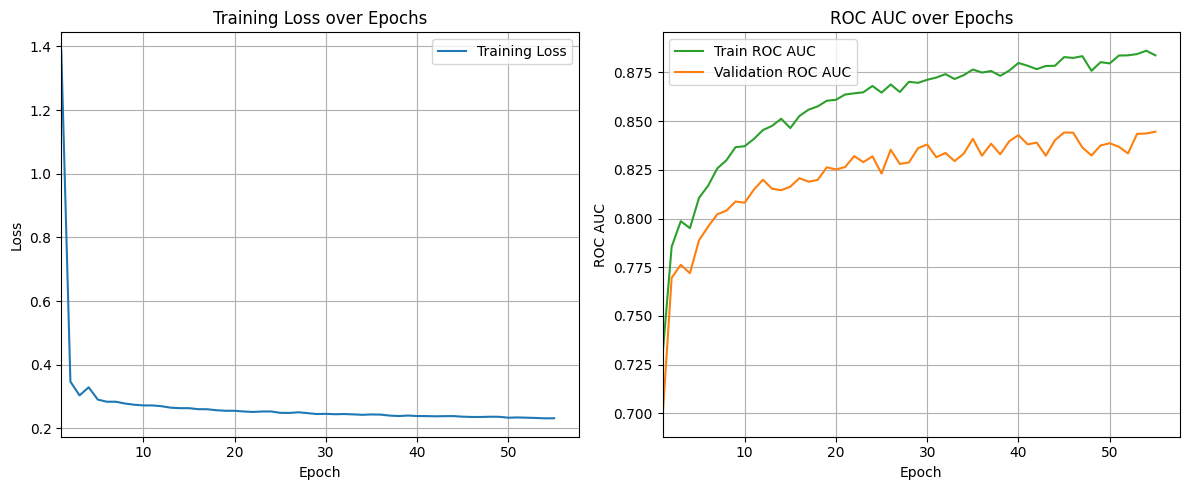

In [11]:
import matplotlib.pyplot as plt
# Unpack ROC AUCs
train_rocauc_vals = [r[0] for r in rocauc]
val_rocauc_vals = [r[1] for r in rocauc]
test_rocauc_vals = [r[2] for r in rocauc]  # optional
epochs = 55
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
# plt.ylim(bottom=0)
plt.xlim(left=1)
plt.legend()

# Plot ROC AUCs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_rocauc_vals, label='Train ROC AUC', color='tab:green')
plt.plot(epochs_range, val_rocauc_vals, label='Validation ROC AUC', color='tab:orange')
# plt.plot(epochs_range, test_rocauc_vals, label='Test ROC AUC', color='tab:red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlim(left=1)

plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Troubleshooting CUDA

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())